<a href="https://colab.research.google.com/github/debg48/Rasengan/blob/main/RASEN_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation and Preprocessing

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [3]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['25483_2009.jpg', '60334_2018.jpg', '40651_2013.jpg', '16996_2007.jpg', '32466_2011.jpg', '56489_2017.jpg', '55294_2016.jpg', '48311_2014.jpg', '36528_2012.jpg', '950_2000.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 Denormalizing Tensors to view images from Training Set

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

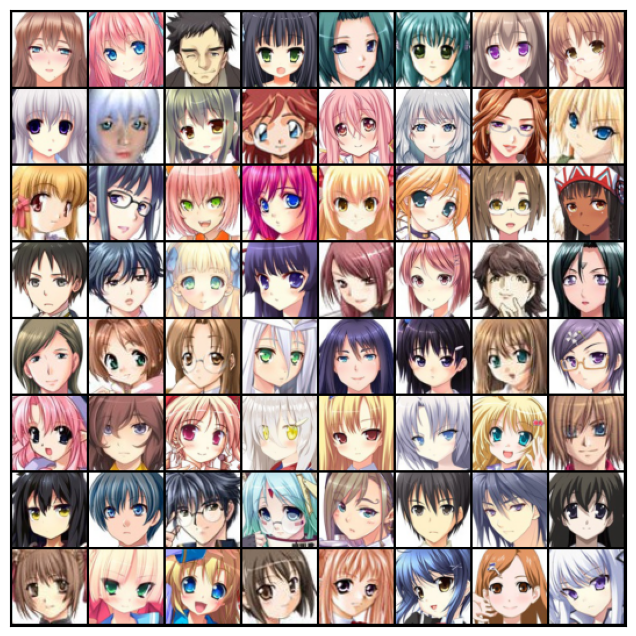

In [11]:
show_batch(train_dl)

# Setting up GPU

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Model Architecture

In [15]:
import torch.nn as nn

## Discriminator

In [30]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.PReLU(),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.PReLU(),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.PReLU(),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [31]:
discriminator = to_device(discriminator, device)

In [32]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): PReLU(num_parameters=1)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): PReLU(num_parameters=1)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): PReLU(num_parameters=1)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): PReLU(num_parameters=1)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Sigmoid()
)

## Generator

In [19]:
latent_size = 128

In [ ]:
# residual blocks
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same"),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding="same"),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding="same"),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding="same"),

In [26]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    # residual blocks
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.PReLU(),
    nn.Conv2d(256, 256,  kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generating outputs with generator network

torch.Size([128, 3, 64, 64])


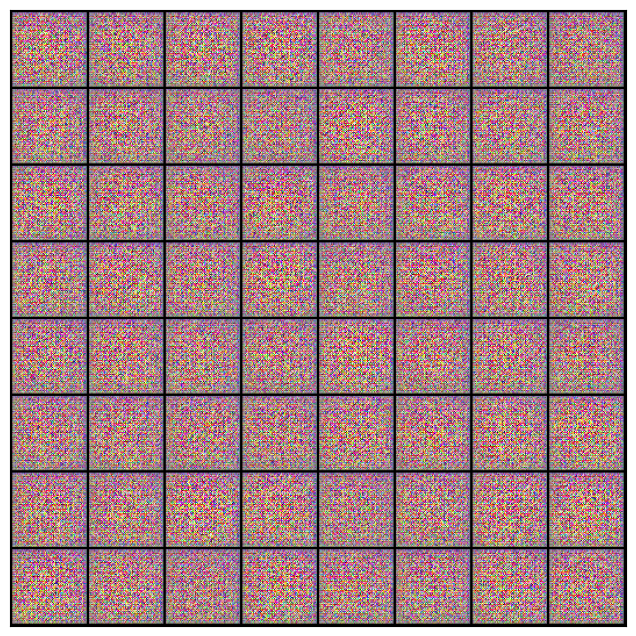

In [27]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [28]:
generator = to_device(generator, device)

In [29]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): PReLU(num_parameters=1)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): PReLU(num_parameters=1)
  (14): Conv2d(256, 256, kern

# Training Pipeline

## Discriminator

In [33]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator

In [34]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

save outputs of generator

In [35]:
from torchvision.utils import save_image

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


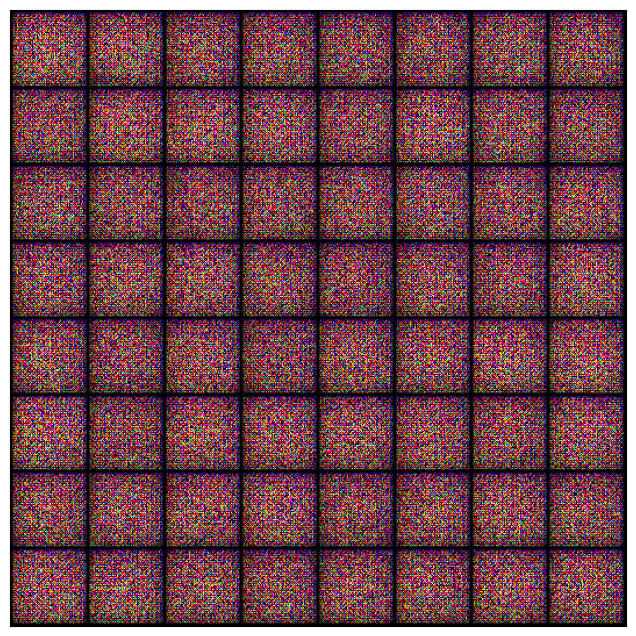

In [39]:
save_samples(0, fixed_latent)

## Training Loop

In [40]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [41]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [44]:
lr = 0.0001
epochs = 25

In [45]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 2.3824, loss_d: 0.7719, real_score: 0.6719, fake_score: 0.2708
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 2.6839, loss_d: 0.8519, real_score: 0.7013, fake_score: 0.3569
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 1.6483, loss_d: 1.1675, real_score: 0.4581, fake_score: 0.1279
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.8532, loss_d: 0.6884, real_score: 0.8295, fake_score: 0.3748
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.2419, loss_d: 0.0995, real_score: 0.9350, fake_score: 0.0273
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 3.1257, loss_d: 0.5009, real_score: 0.7851, fake_score: 0.1730
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 5.0307, loss_d: 0.3335, real_score: 0.9194, fake_score: 0.2075
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.2002, loss_d: 0.2657, real_score: 0.9011, fake_score: 0.1377
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.4520, loss_d: 0.3033, real_score: 0.8874, fake_score: 0.1348
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.9131, loss_d: 1.0131, real_score: 0.5495, fake_score: 0.1145
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.8256, loss_d: 0.2720, real_score: 0.8932, fake_score: 0.1030
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.7087, loss_d: 0.2992, real_score: 0.8623, fake_score: 0.1015
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.8014, loss_d: 0.1815, real_score: 0.9544, fake_score: 0.1184
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.6443, loss_d: 0.3370, real_score: 0.9506, fake_score: 0.2307
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.4482, loss_d: 0.0891, real_score: 0.9621, fake_score: 0.0457
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.0669, loss_d: 0.1619, real_score: 0.9280, fake_score: 0.0723
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.3091, loss_d: 0.4355, real_score: 0.7687, fake_score: 0.0458
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.4761, loss_d: 0.2665, real_score: 0.8616, fake_score: 0.0681
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.8077, loss_d: 0.2810, real_score: 0.9631, fake_score: 0.2048
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.3692, loss_d: 0.1470, real_score: 0.9377, fake_score: 0.0533
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.9902, loss_d: 0.4926, real_score: 0.9436, fake_score: 0.2911
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.3601, loss_d: 0.1054, real_score: 0.9450, fake_score: 0.0439
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.0264, loss_d: 0.1600, real_score: 0.8928, fake_score: 0.0156
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.0725, loss_d: 0.1504, real_score: 0.9495, fake_score: 0.0858
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.1865, loss_d: 0.2143, real_score: 0.8805, fake_score: 0.0295
Saving generated-images-0025.png


In [46]:
losses_g, losses_d, real_scores, fake_scores = history

save model checkpoint

In [47]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

# Visualizing Results

In [48]:
from IPython.display import Image

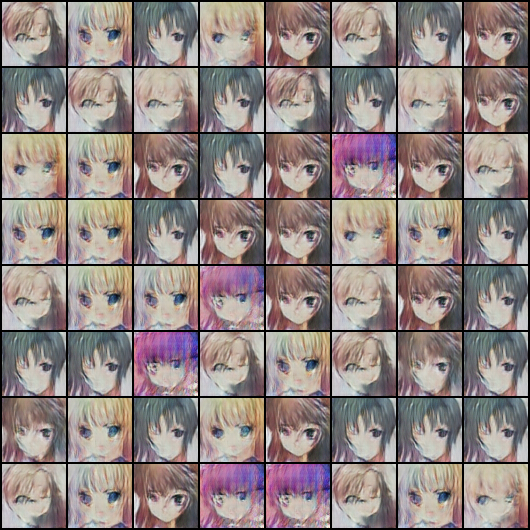

In [49]:
Image('./generated/generated-images-0001.png')

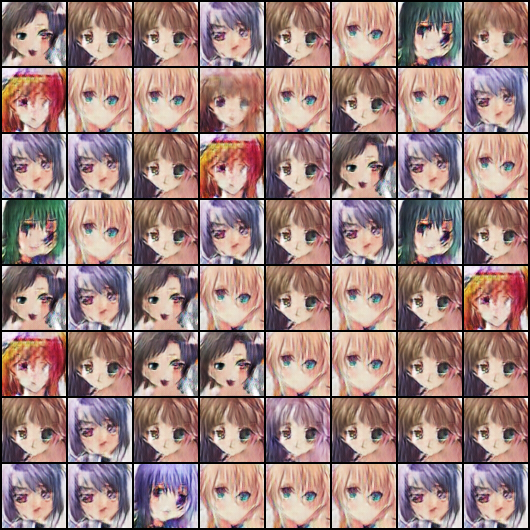

In [50]:
Image('./generated/generated-images-0010.png')

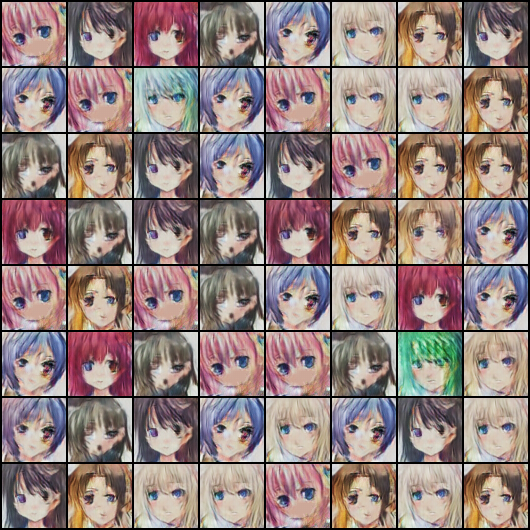

In [51]:
Image('./generated/generated-images-0020.png')

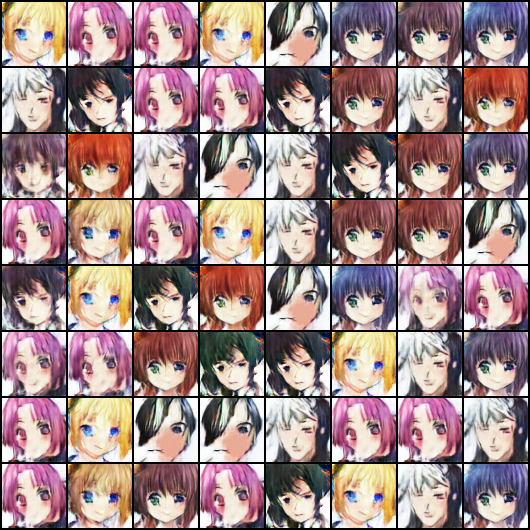

In [52]:
Image('./generated/generated-images-0025.png')

making a video from output images

In [53]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

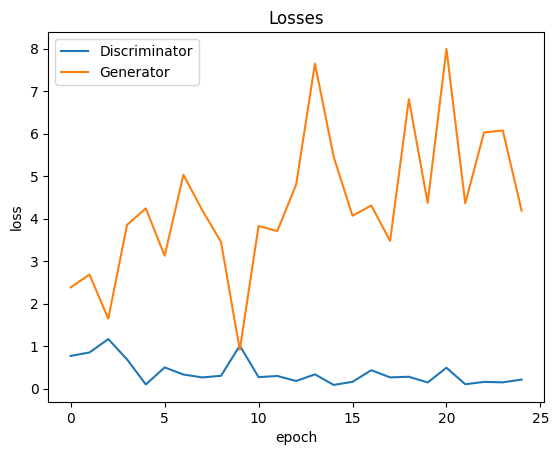

In [54]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

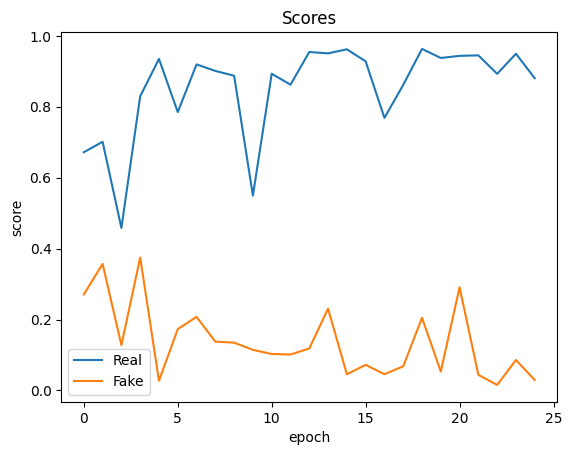

In [55]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');